[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Colunas disponíveis em ensino: ['NO_IES', 'SG_UF_IES', 'TP_CATEGORIA_ADMINISTRATIVA', 'QT_TEC_TOTAL', 'QT_DOC_TOTAL', 'QT_DOC_EX_DOUT', 'QT_DOC_EX_MEST', 'QT_PERIODICO_ELETRONICO', 'QT_LIVRO_ELETRONICO', 'IN_ACESSO_PORTAL_CAPES', 'IN_REPOSITORIO_INSTITUCIONAL', 'IN_SERVICO_INTERNET']
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.71      0.71      0.71         7

    accuracy                           0.60        10
   macro avg       0.52      0.52      0.52        10
weighted avg       0.60      0.60      0.60        10

Acurácia média (validação cruzada): 0.6977777777777778


<ipython-input-5-fbdc61705445>:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados['salario_medio'].fillna(dados['salario_medio'].median(), inplace=True)
<ipython-input-5-fbdc61705445>:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

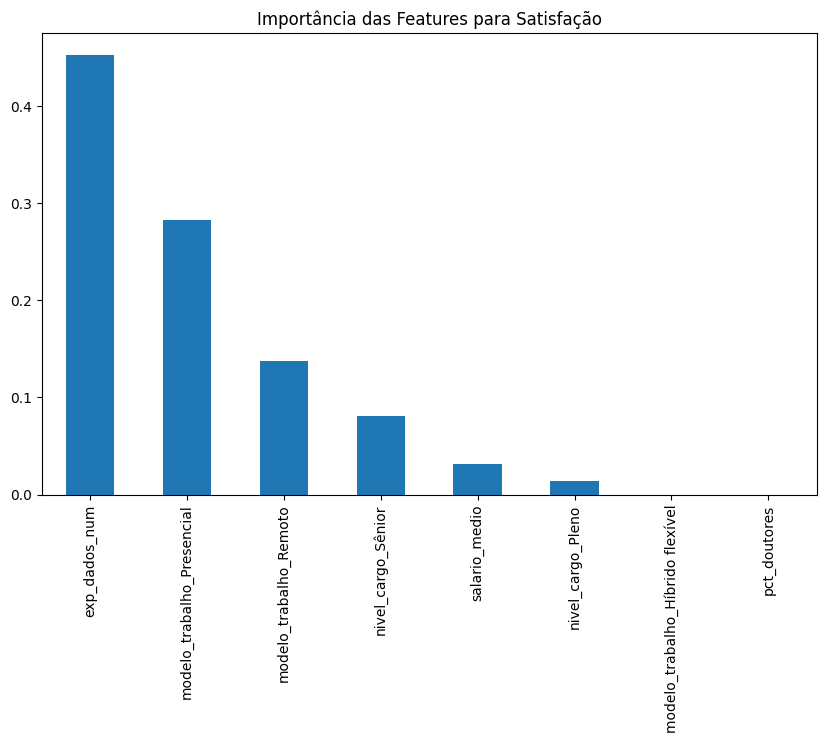

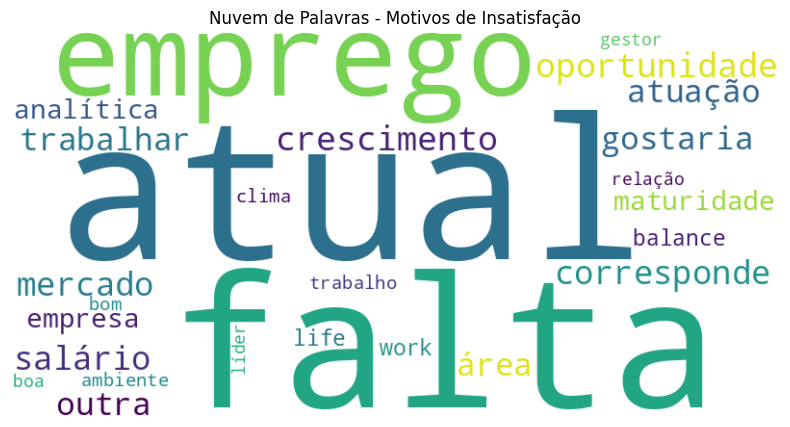

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Baixar recursos do NLTK
nltk.download('stopwords')
stop_words = stopwords.words('portuguese')

# Carregar os dados
dados = pd.read_csv('dados_processados.csv')
ensino = pd.read_excel('Analise_Ensino_Superior_Consolidada.xlsx')

# Verificar colunas do DataFrame ensino
print("Colunas disponíveis em ensino:", ensino.columns.tolist())

# Pré-processamento
# Calcular porcentagem de doutores se '%_Doutores' não existir
if '%_Doutores' not in ensino.columns:
    ensino['pct_doutores'] = (ensino['QT_DOC_EX_DOUT'] / ensino['QT_DOC_TOTAL'] * 100).fillna(0)
else:
    ensino['pct_doutores'] = ensino['%_Doutores']

# Cruzar estado com SG_UF_IES para adicionar pct_doutores
estado_doutores = ensino.groupby('SG_UF_IES')['pct_doutores'].mean().reset_index()
dados = dados.merge(estado_doutores, left_on='estado', right_on='SG_UF_IES', how='left')

# Tratar valores ausentes
dados['salario_medio'].fillna(dados['salario_medio'].median(), inplace=True)
dados['exp_dados_num'].fillna(0, inplace=True)
dados['motivo_insatisfacao'].fillna('', inplace=True)
dados['pct_doutores'].fillna(dados['pct_doutores'].median(), inplace=True)

# Selecionar features
features = ['salario_medio', 'exp_dados_num', 'pct_doutores', 'modelo_trabalho', 'nivel_cargo']
X = dados[features]
y = dados['satisfacao_binaria']

# Codificar variáveis categóricas
X = pd.get_dummies(X, columns=['modelo_trabalho', 'nivel_cargo'], drop_first=True)

# Normalizar variáveis numéricas
scaler = StandardScaler()
X[['salario_medio', 'exp_dados_num', 'pct_doutores']] = scaler.fit_transform(X[['salario_medio', 'exp_dados_num', 'pct_doutores']])

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Treinar árvore de decisão
clf = DecisionTreeClassifier(max_depth=5, min_samples_split=5, criterion='gini', random_state=42)
clf.fit(X_train, y_train)

# Avaliar o modelo
y_pred = clf.predict(X_test)
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))

# Validação cruzada
scores = cross_val_score(clf, X, y, cv=5)
print("Acurácia média (validação cruzada):", scores.mean())

# Importância das features
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Importância das Features para Satisfação')
plt.show()

# Análise de texto (motivo_insatisfacao)
tfidf = TfidfVectorizer(max_features=100, stop_words=stop_words)
tfidf_matrix = tfidf.fit_transform(dados['motivo_insatisfacao'])
terms = tfidf.get_feature_names_out()
word_scores = tfidf_matrix.sum(axis=0).A1
word_importance = pd.Series(word_scores, index=terms).sort_values(ascending=False)

# Nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_importance)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras - Motivos de Insatisfação')
plt.savefig('wordcloud_insatisfacao.png')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-4-0f5b9ab2fdac>:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados['salario_medio'].fillna(dados['salario_medio'].median(), inplace=True)
<ipython-input-4-0f5b9ab2fdac>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the in

Árvore de decisão salva como 'arvore_decisao_satisfacao.png'


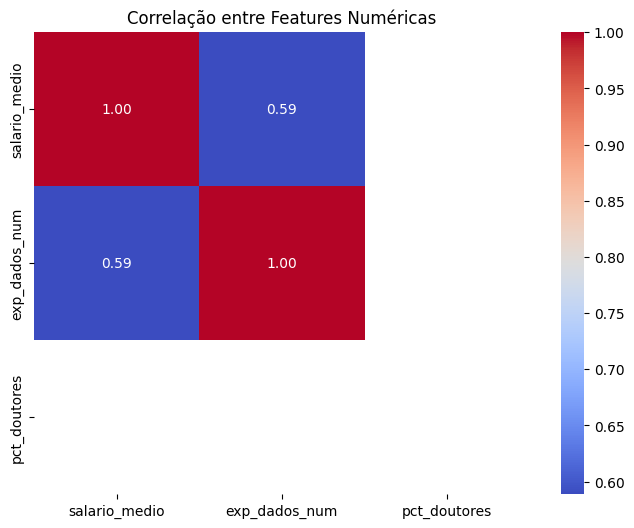

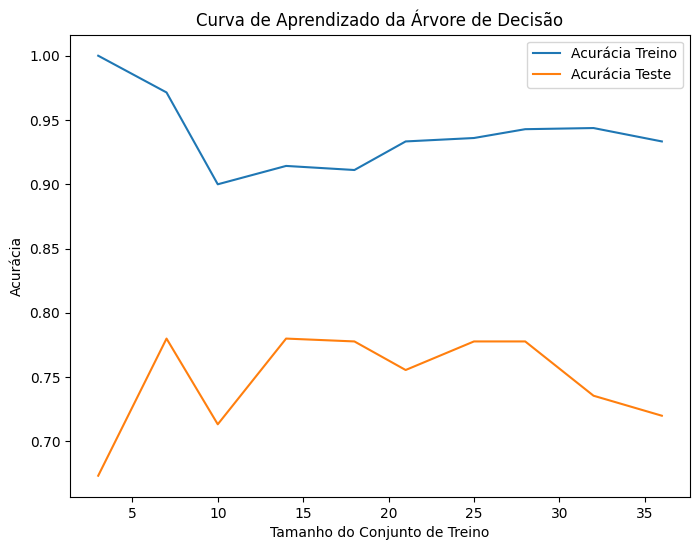

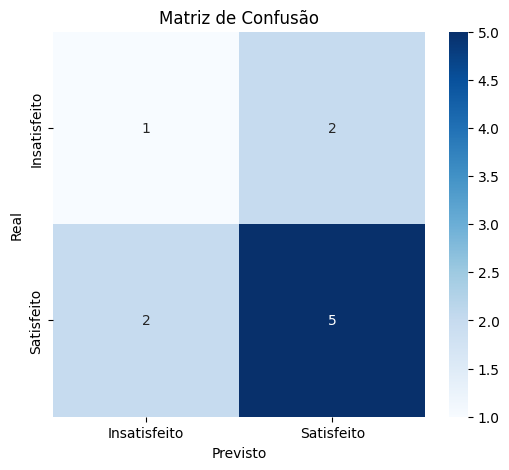


Matriz de Probabilidades (primeiras 10 linhas):
   Prob_Insatisfeito  Prob_Satisfeito  Real  Previsto
0               0.00             1.00     1         1
1               0.25             0.75     0         1
2               1.00             0.00     1         0
3               0.00             1.00     0         1
4               0.00             1.00     1         1
5               0.00             1.00     1         1
6               1.00             0.00     1         0
7               0.00             1.00     1         1
8               0.00             1.00     1         1
9               1.00             0.00     0         0
Matriz de probabilidades salva como 'matriz_probabilidades.csv'

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.71      0.71      0.71         7

    accuracy                           0.60        10
   macro avg       0.52      0.52      0.52  

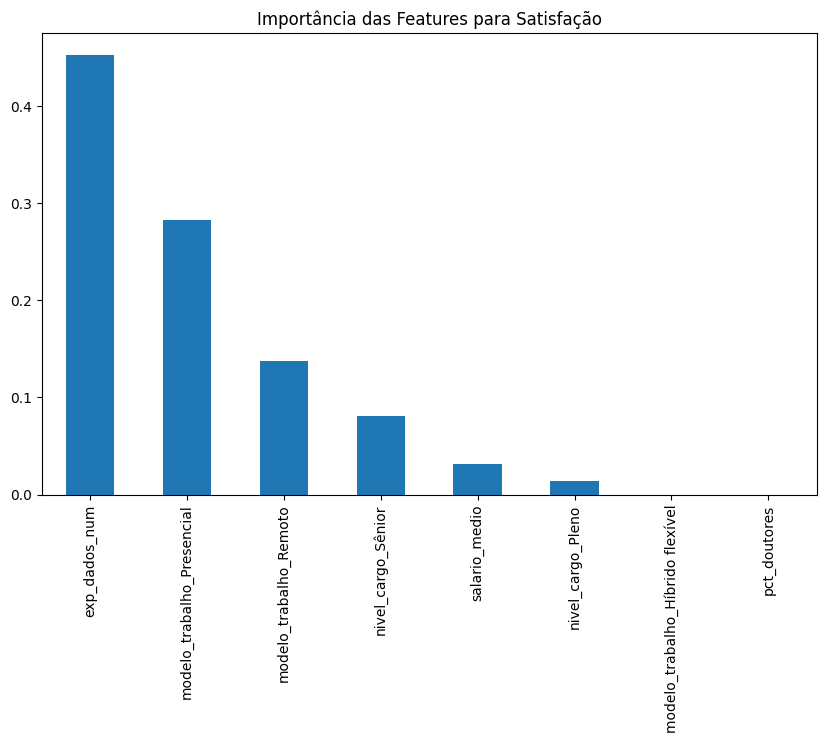

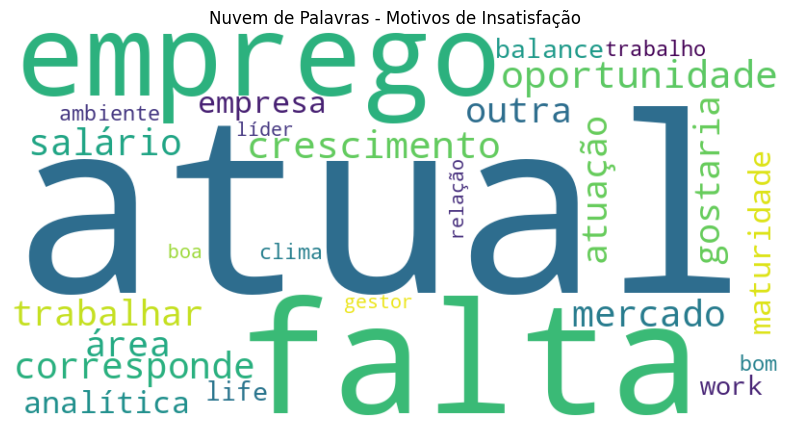

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import graphviz
from sklearn.tree import export_graphviz

# Configurações iniciais
nltk.download('stopwords')
stop_words = stopwords.words('portuguese')

# Carregar os dados (assumindo que os arquivos existem)
dados = pd.read_csv('dados_processados.csv')
ensino = pd.read_excel('Analise_Ensino_Superior_Consolidada.xlsx')

# Pré-processamento
if '%_Doutores' not in ensino.columns:
    ensino['pct_doutores'] = (ensino['QT_DOC_EX_DOUT'] / ensino['QT_DOC_TOTAL'] * 100).fillna(0)
else:
    ensino['pct_doutores'] = ensino['%_Doutores']
estado_doutores = ensino.groupby('SG_UF_IES')['pct_doutores'].mean().reset_index()
dados = dados.merge(estado_doutores, left_on='estado', right_on='SG_UF_IES', how='left')
dados['salario_medio'].fillna(dados['salario_medio'].median(), inplace=True)
dados['exp_dados_num'].fillna(0, inplace=True)
dados['motivo_insatisfacao'].fillna('', inplace=True)
dados['pct_doutores'].fillna(dados['pct_doutores'].median(), inplace=True)

# Selecionar features
features = ['salario_medio', 'exp_dados_num', 'pct_doutores', 'modelo_trabalho', 'nivel_cargo']
X = dados[features]
y = dados['satisfacao_binaria']
X = pd.get_dummies(X, columns=['modelo_trabalho', 'nivel_cargo'], drop_first=True)
scaler = StandardScaler()
X[['salario_medio', 'exp_dados_num', 'pct_doutores']] = scaler.fit_transform(X[['salario_medio', 'exp_dados_num', 'pct_doutores']])

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Treinar árvore de decisão
clf = DecisionTreeClassifier(max_depth=5, min_samples_split=5, criterion='gini', random_state=42)
clf.fit(X_train, y_train)

# Gerar previsões (movido para cá para evitar o erro)
y_pred = clf.predict(X_test)

# --- Novos Gráficos ---
# 1. Visualização da Árvore de Decisão
dot_data = export_graphviz(clf, out_file=None, feature_names=X.columns,
                           class_names=['Insatisfeito', 'Satisfeito'], filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph.render("arvore_decisao_satisfacao", format="png", view=False)
print("Árvore de decisão salva como 'arvore_decisao_satisfacao.png'")

# 2. Heatmap de correlação entre features numéricas
plt.figure(figsize=(8, 6))
sns.heatmap(X[['salario_medio', 'exp_dados_num', 'pct_doutores']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação entre Features Numéricas')
plt.savefig('heatmap_correlacao.png')
plt.show()

# 3. Curva de aprendizado
train_sizes, train_scores, test_scores = learning_curve(clf, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Acurácia Treino')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Acurácia Teste')
plt.xlabel('Tamanho do Conjunto de Treino')
plt.ylabel('Acurácia')
plt.title('Curva de Aprendizado da Árvore de Decisão')
plt.legend()
plt.savefig('curva_aprendizado.png')
plt.show()

# --- Matriz de Solução ---
# 1. Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Insatisfeito', 'Satisfeito'],
            yticklabels=['Insatisfeito', 'Satisfeito'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.savefig('matriz_confusao.png')
plt.show()

# 2. Matriz de Probabilidades Previstas
probs = clf.predict_proba(X_test)
matriz_probs = pd.DataFrame(probs, columns=['Prob_Insatisfeito', 'Prob_Satisfeito'])
matriz_probs['Real'] = y_test.values
matriz_probs['Previsto'] = y_pred
print("\nMatriz de Probabilidades (primeiras 10 linhas):")
print(matriz_probs.head(10))
matriz_probs.to_csv('matriz_probabilidades.csv', index=False)
print("Matriz de probabilidades salva como 'matriz_probabilidades.csv'")

# --- Avaliação do Modelo (seu código original) ---
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

# Validação cruzada
scores = cross_val_score(clf, X, y, cv=5)
print("Acurácia média (validação cruzada):", scores.mean())

# Importância das features
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Importância das Features para Satisfação')
plt.savefig('importancia_features.png')
plt.show()

# Análise de texto (motivo_insatisfacao)
tfidf = TfidfVectorizer(max_features=100, stop_words=stop_words)
tfidf_matrix = tfidf.fit_transform(dados['motivo_insatisfacao'])
terms = tfidf.get_feature_names_out()
word_scores = tfidf_matrix.sum(axis=0).A1
word_importance = pd.Series(word_scores, index=terms).sort_values(ascending=False)

# Nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_importance)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras - Motivos de Insatisfação')
plt.savefig('wordcloud_insatisfacao.png')
plt.show()